 Firn models code adapapted from from MATLAB Grinstead 2020 to Python 
https://www.mathworks.com/matlabcentral/fileexchange/47386-steady-state-snow-and-firn-density-model
We use the Nabarro-Herring firn model(Arthern, 2010 (Eqn. 4)), fed with average annual temperature and average annual accumulation based on the nearest automatic snow weather station to each glacier and a standard atmospheric lapse rate (-6.0 K km$^{-1}$). We scale firn column thickness by firn area for each bin.

In [1]:
## BP + BM May 30, 2021
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
from matplotlib import pylab
import pickle
import matplotlib.dates as mdates

def cm2inch(*tupl):  ### plots in cm ##frontiers 180 mm for full width, 85 mm half width (1 column) figures
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


import warnings
warnings.filterwarnings("ignore")

In [2]:
gl = 4 # number to select glacier
Glacier = ['Conrad', 'Illecillewaet','Kokanee', 'Nordic', 'Zillmer']
glacier = ['conrad', 'illecillewaet','kokanee', 'nordic', 'zillmer']
fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
print("You selected", Glacier[gl] ,'Glacier')

You selected Zillmer Glacier


In [3]:
files = ['/home/pelto/Desktop/snow_pillows/Conrad/DataSetExport-TA.Telemetry@2A33P-20210413185732.csv',
         '/home/pelto/Desktop/snow_pillows/Caribou_Creek/DataSetExport-TA.Telemetry@2A31P-20210413193149.csv',
         '/home/pelto/src/Kokanee/Redfish/DataSetExport-TA.Working@2D14P-20210311201757.csv',       
        '/home/pelto/Desktop/snow_pillows/Colpitti/DataSetExport-TA.Telemetry@2A30P-20210420223619.csv',
         '/home/pelto/Desktop/snow_pillows/Azure_creek/DataSetExport-TA.Working@1E08P-20210420195353.csv']
         
path = files[gl]

-4.136988936786454
-0.8248120581370547
0.5699724026650467
-0.9385596497693515


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


0.32552090969378017


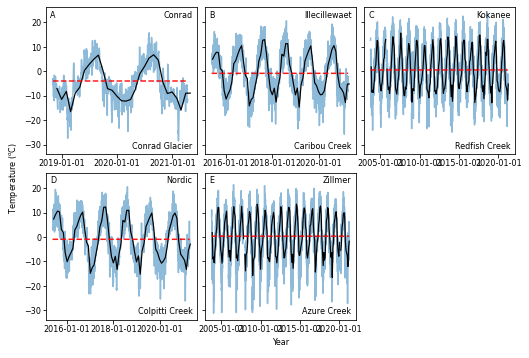

In [4]:
font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1';pylab.rcParams['ytick.major.pad']='1'
letter=['A','B','C','D','E'];pillows=['Conrad Glacier', 'Caribou Creek', 'Redfish Creek', 'Colpitti Creek', 'Azure Creek']
TA_ref=[]
j=0;k=0
fig, ax = plt.subplots(2,3, figsize=(cm2inch(18, 12)), sharey=True) 
for i in range(5):
    path = files[i]
    TA = pd.read_csv(path , header=2)
    # TA[:10]
    np.nanmean(TA['Value (Celsius)'])
    TA.rename(columns={'Value (Centimetres)':'depth'},inplace=True)
    TA['Date'] =  pd.to_datetime(TA['Timestamp (UTC)'], format='%Y-%m-%d %H:%M:%S')
    TA['hour'] = TA['Date'].dt.hour  ##might have to make dt datetime on restart
    # TA['date_only'] = TA['Date'].dt.date
    TA.reset_index(inplace=True);
    TA[:10]

    # monthly
    Mavg_TA = TA.groupby(pd.Grouper(freq='M', key='Date')).mean()
    # daily
    davg_TA = TA.groupby(pd.Grouper(freq='D', key='Date')).mean()
    # davg_TA

    # all months value
    TA['month'] = TA['Date'].apply(lambda t:t.month)
    TA['day'] = TA['Date'].apply(lambda t:t.day)

    # then group by day and month and get the mean:
    TA_month = TA.groupby('month').mean()
    # TA_month
    T = np.mean(TA_month['Value (Celsius)']) 
    TA_ref.append(T)
    davg_TA['TA_ref'] = T
    print(T)

    ax[j,k].plot(davg_TA.index,davg_TA.TA_ref,ls='--',c='r',alpha=0.9,zorder=4)
    ax[j,k].plot(Mavg_TA.index,Mavg_TA['Value (Celsius)'], c='k', lw=1.2,zorder=3)
    ax[j,k].plot(davg_TA.index,davg_TA['Value (Celsius)'], zorder=2, alpha=0.5)
   
    if i == 2 or i==4:
        year = mdates.YearLocator(5)
        ax[j,k].xaxis.set_major_locator(year)
    elif i== 1 or i ==3:
        year = mdates.YearLocator(2)
        ax[j,k].xaxis.set_major_locator(year)
    # Major ticks every year.
    else:
        year = mdates.YearLocator()
        ax[j,k].xaxis.set_major_locator(year)
    ax[j,k].text(0.03, 0.93, letter[i], transform=ax[j,k].transAxes)
    ax[j,k].text(0.97, 0.93, Glacier[i], transform=ax[j,k].transAxes, ha='right') 
    ax[j,k].text(0.97, 0.04, pillows[i], transform=ax[j,k].transAxes, ha='right') 
    
    k += 1
    if i == 2: 
        j += 1; k = 0 
    ax[1,0].set(ylabel='                                                      Temperature ($^o$C)')
    ax[1,1].set(xlabel='Year');ax[1,2].axis('off');
    
fig_path= '/home/pelto/Desktop/ice_flux/figures/'
fig.subplots_adjust(bottom=0.07, top=0.99, hspace=0.125, left=0.07, right=0.99, wspace=0.05)
fig.savefig(fig_path + 'ASWS_temperatures.png', dpi=300)
plt.show()
# TA_ref = np.mean(davg_TA['Value (Celsius)'])

In [5]:
z_stations = [2599,2201,2104,2131,1652]
z_ref = z_stations[gl]

rho_file = ['conrad_rho_new11.csv','illec_rho_5.csv','kokanee_rho_6.csv','nordic_rho.csv','zillmer_rho.csv']
Ba = pd.read_csv(fl_path + rho_file[gl])

with open(fl_path +glacier[gl] +'_new16.pkl', 'rb') as f:
    FB = pickle.load(f)


Ba['dem_med']=FB.dem_med
# Ba.reset_index(inplace=True)
temp=[]
for i in range(len(Ba)):
    t= (Ba.dem_med[i]-z_ref)/1000 * -6 + TA_ref[gl]
    temp.append(t)

Ba['Tavg']=temp
Ba

,bin,rho_2016,rho_2017,rho_2018,rho_mean,FirnA,Vfirn,firn_area,ba,dem_med,Tavg
0,0,910,910,910,910,0.000000,0,0.00,0.00,2071.958984,-2.194233
1,1,900,900,900,900,0.016725,0,0.02,0.00,2208.598877,-3.014072
2,2,890,890,890,890,0.085827,0,0.21,0.44,2359.753174,-3.920998
3,3,850,850,850,850,0.506163,0,0.70,1.06,2528.045410,-4.930752
4,4,800,800,800,800,0.994431,0,0.99,1.23,2607.510010,-5.407539


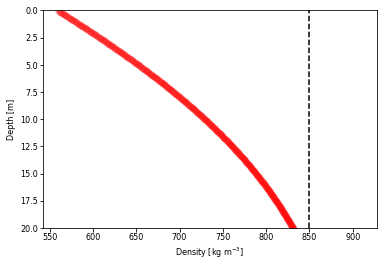

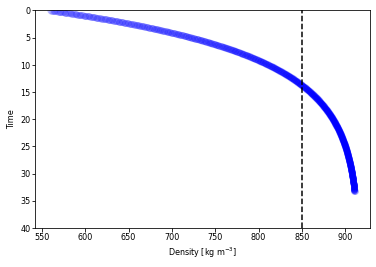

All Done!


In [7]:
## import required modules

n_GLEN    = 3.0                       # Glen's non - linearity index
A_GLEN    = 7.5738e-17                # Glen's law parameter in Pa, (Year units)

ice       = 850.
RHO_I     = 917.0                     # Density (SI units)
RHO_C     = 550.0
RHO_W     = 1000.0

R         = 8.314                     # Gas constant

g         = 9.81                      # Gravity (SI units, rho*g has units of Pa)

sec_yr    = 60*60*24*365.25


def firn_profile(MODEL, z, R, T, Tavg, B_DOT, RHO_H):
    T    = T    + 273.15 ## convert to Kelvin
    Tavg = Tavg + 273.15 ## convert to Kelvin
    
    if MODEL == 'HLJohnsen':
        c0   = 0.85*11*(B_DOT/RHO_H)*np.exp(-10160./(R*Tavg))
        c1   = 1.15*575*np.sqrt(B_DOT/RHO_H)*np.exp(-21400./(R*Tavg))
    
    elif MODEL == 'HerronLangway':
        c0   =11*(B_DOT/RHO_W)*np.exp(-10160./(R*Tavg))
        c1   =575*np.sqrt(B_DOT/RHO_W)*np.exp(-21400./(R*Tavg))
    
    elif MODEL == 'LiZwally':
        c0   = (B_DOT/RHO_I)*(139.21-0.542*Tavg)*8.36*(273.15-T)**-2.061
        c1   = c0
    
    elif MODEL == 'Helsen':
        c0   = (B_DOT/RHO_I)*(76.138-0.28965*Tavg)*8.36*(273.15-T)**-2.061
        c1   = c0
        
    elif MODEL == 'Nabarro-Herring':
        Ec=60.0e3
        Eg=42.2e3
        c0=0.07*B_DOT*g*np.exp(-Ec/(R*T)+Eg/(R*Tavg))
        c1=0.03*B_DOT*g*np.exp(-Ec/(R*T)+Eg/(R*Tavg))
    
    else:
        print('Unknown density model. Bailing out')
        return
    
    
    k0   = c0/B_DOT
    k1   = c1/B_DOT
        
    
    ## critical depth at which RHO = RHOC
    zc   = (np.log(RHO_C/(RHO_I-RHO_C))-np.log(RHO_S/(RHO_I-RHO_S)))/(k0*RHO_I)
    
    upix = np.where(z <= zc)
    dnix = np.where(z > zc)
    
    q       = np.zeros(len(z))
    q[dnix] = np.exp(k1*RHO_I*(z[dnix]-zc)+np.log(RHO_C/(RHO_I-RHO_C)))
    q[upix] = np.exp(k0*RHO_I*z[upix]+np.log(RHO_S/(RHO_I-RHO_S)))
    RHO     = q*RHO_I/(1+q)

    tc      = (np.log(RHO_I-RHO_S)-np.log(RHO_I-RHO_C))/c0
    tc      = (np.log(RHO_I-RHO_S)-np.log(RHO_I-RHO_C))/c0  
    t       = np.zeros(len(z)) 
    t[upix] = (np.log(RHO_I-RHO_S)-np.log(RHO_I-RHO[upix]))/c0
    t[dnix] = (np.log(RHO_I-RHO_C)-np.log(RHO_I-RHO[dnix]))/c1+tc
    zieq    = t*B_DOT/RHO_I  
    
    return RHO, zieq, t

z     = np.arange(0, 20, 0.1)
# Tavg  = -5.0 
T     =  0.0 
#B_DOT =  330 # kg m^-2 a^-1

RHO_S = 572 
cd = [];cp = [];dp=[];time=[]
for i in range(len(Ba)):
    z     = np.arange(0, 50, 0.05);#T     = 0.0 
    Tavg=Ba.Tavg[i];B_DOT=Ba.ba[i]*1000; T=Tavg
    RHO, zieg, t = firn_profile('Nabarro-Herring', z, R, T, Tavg, B_DOT, RHO_S)
    
    Firn = pd.DataFrame(list(zip(RHO,t,z)), columns=['density', 'time', 'depth'])
    Firn['mass']=0.05*Firn.density
    F = Firn[Firn.density<900]
    column_density = F.mass.sum() / F.depth.max()  
    cd.append(column_density)
    
    ## find value closest to 850 kg m-3
    depth=Firn.iloc[(Firn['density']-900).abs().argsort()[:1]]
    dp.append(depth.depth.values[0])
    time.append(depth.time.values[0])
    ## find depth at 1 year
    yr_1 = Firn.iloc[(Firn['time']-1.0).abs().argsort()[:1]]
    cp.append(yr_1.depth.values[0])
             
#### plotting
plt.figure()
plt.axvline(x=850,ls='--',c='k')
plt.plot(RHO, z, 'ro', alpha=0.2)
#     coefficients = np.polyfit(RHO, z, 5); poly = np.poly1d(coefficients);
#     new_x = np.arange(550., 850.,0.1); new_y = poly(new_x);plt.plot(new_x, new_y,c='k')
plt.ylim([20, 0])

# plt.yscale('log');
# plt.xscale('log')
plt.xlabel('Density [kg m$^{-3}$]')
plt.ylabel('Depth [m]')
plt.show()

# plt.figure()
plt.plot(RHO, t, 'bo',alpha=0.1)
#     coeff_t = np.polyfit(RHO, t, 5); poly_t = np.poly1d(coeff_t);
#     new_x = np.arange(550., 850.,0.1); new_y = poly_t(new_x);plt.plot(new_x, new_y, c='k')
plt.axvline(x=850,ls='--',c='k')
plt.ylim([40, 0])
plt.xlabel('Density [kg m$^{-3}$]')
plt.ylabel('Time')
plt.show()


print('All Done!')


In [350]:
Ba['column_density']=cd; Ba['column_depth']=dp
Ba['time']=time;  Ba['V_firn']=cp
Ba['V_firn2']=Ba.column_depth / Ba.time
Ba['V_firn_NH']= Ba.V_firn2*Ba.firn_area
Ba['Vfirn']= (np.abs((Ba.ba/0.910) - (Ba.ba/0.572))) * Ba.firn_area
BA = Ba[['bin', 'ba','firn_area', 'Tavg', 'Vfirn', 'column_density', 'column_depth', 'time']].copy()  
BA.to_csv(fl_path+ 'RHO.csv')

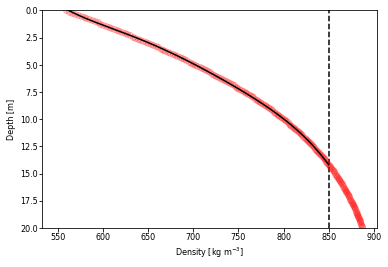

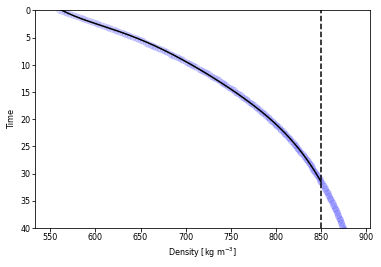

All Done!


In [136]:
## import required modules


n_GLEN    = 3.0                       # Glen's non - linearity index
A_GLEN    = 7.5738e-17                # Glen's law parameter in Pa, (Year units)

RHO_I     = 917.0                     # Density (SI units)
RHO_C     = 550.0
RHO_W     = 1000.0

R         = 8.314                     # Gas constant

g         = 9.81                      # Gravity (SI units, rho*g has units of Pa)

sec_yr    = 60*60*24*365.25


def firn_profile(MODEL, z, R, T, Tavg, B_DOT, RHO_H):
    T    = T    + 273.15 ## convert to Kelvin
    Tavg = Tavg + 273.15 ## convert to Kelvin
    
    if MODEL == 'HLJohnsen':
        c0   = 0.85*11*(B_DOT/RHO_H)*np.exp(-10160./(R*Tavg))
        c1   = 1.15*575*np.sqrt(B_DOT/RHO_H)*np.exp(-21400./(R*Tavg))
    
    elif MODEL == 'HerronLangway':
        c0   =11*(B_DOT/RHO_W)*np.exp(-10160./(R*Tavg))
        c1   =575*np.sqrt(B_DOT/RHO_W)*np.exp(-21400./(R*Tavg))
    
    elif MODEL == 'LiZwally':
        c0   = (B_DOT/RHO_I)*(139.21-0.542*Tavg)*8.36*(273.15-T)**-2.061
        c1   = c0
    
    elif MODEL == 'Helsen':
        c0   = (B_DOT/RHO_I)*(76.138-0.28965*Tavg)*8.36*(273.15-T)**-2.061
        c1   = c0
        
    elif MODEL == 'Nabarro-Herring':
        Ec=60.0e3
        Eg=42.2e3
        c0=0.07*B_DOT*g*np.exp(-Ec/(R*T)+Eg/(R*Tavg))
        c1=0.03*B_DOT*g*np.exp(-Ec/(R*T)+Eg/(R*Tavg))
    
    else:
        print('Unknown density model. Bailing out')
        return
    
    
    k0   = c0/B_DOT
    k1   = c1/B_DOT
        
    
    ## critical depth at which RHO = RHOC
    zc   = (np.log(RHO_C/(RHO_I-RHO_C))-np.log(RHO_S/(RHO_I-RHO_S)))/(k0*RHO_I)
    
    upix = np.where(z <= zc)
    dnix = np.where(z > zc)
    
    q       = np.zeros(len(z))
    q[dnix] = np.exp(k1*RHO_I*(z[dnix]-zc)+np.log(RHO_C/(RHO_I-RHO_C)))
    q[upix] = np.exp(k0*RHO_I*z[upix]+np.log(RHO_S/(RHO_I-RHO_S)))
    RHO     = q*RHO_I/(1+q)

    tc      = (np.log(RHO_I-RHO_S)-np.log(RHO_I-RHO_C))/c0
    tc      = (np.log(RHO_I-RHO_S)-np.log(RHO_I-RHO_C))/c0  
    t       = np.zeros(len(z)) 
    t[upix] = (np.log(RHO_I-RHO_S)-np.log(RHO_I-RHO[upix]))/c0
    t[dnix] = (np.log(RHO_I-RHO_C)-np.log(RHO_I-RHO[dnix]))/c1+tc
    zieq    = t*B_DOT/RHO_I  
    
    return RHO, zieq, t

z     = np.arange(0, 20, 0.1)
# Tavg  = -5.0 
T     = -2.0 
B_DOT =  330 # kg m^-2 a^-1

RHO_S = 572 
RHO, zieg, t = firn_profile('Nabarro-Herring', z, R, T, Tavg, B_DOT, RHO_S)
# RHO, zieg, t = firn_profile('HerronLangway', z, R, T, Tavg, B_DOT, RHO_S)
# plt.figure()
plt.axvline(x=850,ls='--',c='k')
plt.plot(RHO, z, 'ro', alpha=0.2)
coefficients = np.polyfit(RHO, z, 5); poly = np.poly1d(coefficients);
new_x = np.arange(550., 850.,0.1); new_y = poly(new_x);plt.plot(new_x, new_y,c='k')
plt.ylim([20, 0])

# plt.yscale('log');
# plt.xscale('log')
plt.xlabel('Density [kg m$^{-3}$]')
plt.ylabel('Depth [m]')
plt.show()

# plt.figure()
plt.plot(RHO, t, 'bo',alpha=0.1)
coeff_t = np.polyfit(RHO, t, 5); poly_t = np.poly1d(coeff_t);
new_x = np.arange(550., 850.,0.1); new_y = poly_t(new_x);plt.plot(new_x, new_y, c='k')
plt.axvline(x=850,ls='--',c='k')
plt.ylim([40, 0])
plt.xlabel('Density [kg m$^{-3}$]')
plt.ylabel('Time')
plt.show()


print('All Done!')


In [ ]:
data = pd.DataFrame({'time':t,  'depth':zieg, 'density':RHO }) 
data[:10]

In [ ]:
ice= 850.
## find value closest to 850 kg m-3
data.iloc[(data['density']-ice).abs().argsort()[:1]]

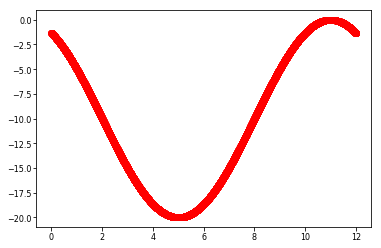

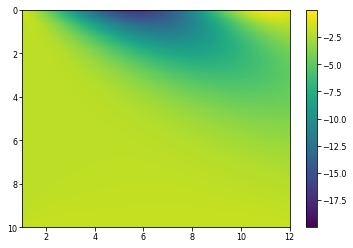

In [277]:
## solving the 1D heat equation using center difference method in space and Crank-Nicolson
## method 
## from http://jkwiens.com/heat-equation-using-finite-difference/

import scipy as sc
import scipy.sparse as sparse
import scipy.sparse.linalg
import numpy as np

# Number of internal points
N = 200
 
# Calculate Spatial Step-Size
h = 1/(N+1.0)
 
# Create Temporal Step-Size, TFinal, Number of Time-Steps
#k = h/2
k =  2.1*(RHO_S/RHO_I)**2 * 1e-05 #1/sec_yr # K is 10e-6 m^2/s

TFinal = 1
NumOfTimeSteps = 10000 #int(TFinal/k)

time = np.arange(0, 12, 12./NumOfTimeSteps)


T_top = -10-10*np.sin(2*np.pi*(10 + time)/12)

plt.plot(time, T_top, 'ro')
plt.show()

# Create grid-points on x axis
x = np.linspace(0,1,N+2)
x = x[1:-1]

i = 0
# Initial Conditions
#u = np.transpose(np.mat(10*np.sin(np.pi*x))) 
#np.transpose(np.mat(x))

u = np.zeros_like(x) - 2.0

u[0] = T_top[i]


# Second-Derivative Matrix
data = np.ones((3, N))
data[1] = -2*data[1]
diags = [-1,0,1]
D2 = sparse.spdiags(data,diags,N,N)/(h**2)
 
# Identity Matrix
I = sparse.identity(N)
 
# Data for each time-step
data = []
u_new = u

for i in range(NumOfTimeSteps):
    # Solve the System: (I - k/2*D2) u_new = (I + k/2*D2)*u_old
    # u = np.zeros_like(x) -2.0 

    u_old = u_new
    
    u_old[0] = T_top[i]
    u_old[-1] = -2.0
    
    A = (I -k/2*D2)
    b = ( I + k/2*D2 )*u_old
    u_new  = np.transpose(np.mat( sparse.linalg.spsolve( A,  b ) ))
 
    # Save Data
    data.append(u_new)

    
plt.imshow(np.squeeze(np.transpose(data)), aspect='auto', extent=[1, 12, 10, 0])
plt.colorbar()
plt.show()

 